In [ ]:

# %load stat_metrics_compare_ensemble_and_SILO.py
"""
Created on Tue Apr 23 14:12:09 2019

@author: nav00a
"""
""""
# xarray opens the netcdf file
import xarray as xr
import requests
import io
import pandas as pd
from plotnine import *
import datetime

nc = xr.open_dataset("../data/ensemble_siloaccess_s.nc")
# type nc in the console to see a summary of the object incl. attributes, dimensions and variables

# Interesting behaviour from xarray: if we define a variable with name "days" and units "days since Jan 1st 1970",
# it automatically reads it in as a datetime object!! It won't do it otherwise, but since this is what we want,
# we just go with it.

# Get some properties (attributes) from the netcdf file
# Attributes are values that the creator of the file has provided as a sort of header
start_month = nc.attrs["hindcast_start_month"]
lon = nc.attrs["longitude"]
lat = nc.attrs["latitude"]

# Get time bounds properties of the .nc file, which aren't declared attributes
minyear = int(min(nc.year))
maxyear = int(max(nc.year))

# Now we convert the imported netcdf object to a pandas dataframe
ensemble_df = nc.to_dataframe().reset_index()
# Can't remember why I convert date to a string, but it was needed for grouping I think (won't work well with a datetime object)
# We also create a "date" column, because it makes more sense than a "days" column formatted as a date
# A "date" column also plays along nicely with the SILO dataset
ensemble_df["date"] = ensemble_df["days"].astype(str)
# Delete "days" column
ensemble_df = ensemble_df.drop(columns="days")


# Get SILO data to compare ensemble with it

# Set SILO url download link (specifying csv format)
silourl = "https://dcdp.research.csiro.au/silogrid?lat="+ str(lat)  +"&lon=" + str(lon) +" &format=csv&start=" + str(minyear) +"0101&stop=" + str(maxyear) +"1231"
# Download SILO data
httpreq = requests.get(silourl, verify=False)

# Use the StringIO function to interpret the csv-like object as if it was saved to disk, then read_csv into pandas
silo_df = pd.read_csv(io.StringIO(httpreq.content.decode('utf-8')))
# This is to remove the header row
silo_df = silo_df.iloc[1:]
# Set columns to correct format
silo_df["date"] = silo_df["date"].astype(str)
silo_df["rad"] = silo_df["rad"].astype(float)
silo_df["tmax"] = silo_df["tmax"].astype(float)
silo_df["tmin"] = silo_df["tmin"].astype(float)
silo_df["rain"] = silo_df["rain"].astype(float)
silo_df["vp"] = silo_df["vp"].astype(float)
silo_df["evap"] = silo_df["evap"].astype(float)


# Compare ensemble and SILO

# We calculate the mean of the ensemble as this is what we want to evaluate
ensemble_df_mean = ensemble_df.groupby(["date"]).mean().reset_index()

# ANALYSIS 

# Plot using ggplot2 for python (plotnine). Currently not too pretty, need to find how to mend the looks
(ggplot(ensemble_df_mean.where(ensemble_df_mean["rain"]>0.1))+
  geom_density(mapping= aes(x = "rain"), color="red", size=1) +
  geom_density(data=silo_df.where(silo_df["rain"]>0.1), mapping= aes(x = "rain"), color="white", size=1, linetype='dotted') +
  theme_minimal()+
  coord_cartesian(xlim =(0, 20))
  )

# Calculate ensemble performance metrics (based on http://www.cawcr.gov.au/projects/verification/)
# We won't use correlation as we're not interested in predicting daily weather but the actual pattern of climate
fcast_vs_obs = ensemble_df_mean.merge(silo_df, on= 'date')

fcast_vs_obs.rename(columns = {"date":"date", "ens":"ens", "rad_x":"rad.fcast","tmax_x":"tmax.fcast","rain_x":"rain.fcast","tmin_x":"tmin.fcast","rad_y":"rad.obs","tmax_y":"tmax.obs","tmin_y":"tmin.obs","rain_y":"rain.obs","vp":"vp.obs","evap":"evap.obs"}, inplace=True)

# Mean error - Answers the question: What is the average forecast error?
# We don't really want this for AgScore but it's informative
fcast_vs_obs["error"] = fcast_vs_obs["rain.fcast"] - fcast_vs_obs["rain.obs"]
mean_error = fcast_vs_obs["error"].mean()
print (mean_error)

# Multiplicative bias - Answers the question: How does the average forecast magnitude compare to the average observed magnitude?
# Bias = mean of forecast divided by mean of observations
bias = fcast_vs_obs["rain.fcast"].mean() / fcast_vs_obs["rain.obs"].mean()
print (bias)

# Next, we need more metrics...

"""




In [1]:
# this is to load Javi's python code into my Jupyter notebook
# %load stat_metrics_compare_ensemble_and_SILO.py
"""
Created on Tue Apr 23 14:12:09 2019

@author: nav00a
"""

import xarray as xr
import requests
import io
import pandas as pd
import datetime


In [2]:
# xarray opens the netcdf file

# type nc in the console to see a summary of the object incl. attributes, dimensions and variables

# Interesting behaviour from xarray: if we define a variable with name "days" and units "days since Jan 1st 1970",
# it automatically reads it in as a datetime object!! It won't do it otherwise, but since this is what we want,
# we just go with it.

nc = xr.open_dataset("../data/ensemble_siloaccess_s.nc")

print(nc)

<xarray.Dataset>
Dimensions:  (ens: 11, ensday: 216, year: 23)
Coordinates:
  * ensday   (ensday) float64 0.0 1.0 2.0 3.0 4.0 ... 212.0 213.0 214.0 215.0
  * year     (year) float64 1.99e+03 1.991e+03 1.992e+03 ... 2.011e+03 2.012e+03
  * ens      (ens) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0
Data variables:
    rad      (ens, year, ensday) float32 ...
    tmax     (ens, year, ensday) float32 ...
    rain     (ens, year, ensday) float32 ...
    tmin     (ens, year, ensday) float32 ...
Attributes:
    latitude:              -35.99
    longitude:             142.92
    hindcast_start_month:  4.0
    ensemble_members:      11.0


In [3]:
# Get some properties (attributes) from the netcdf file
# Attributes are values that the creator of the file has provided as a sort of header

start_month = nc.attrs["hindcast_start_month"]
lon = nc.attrs["longitude"]
lat = nc.attrs["latitude"]

print(start_month)
print(lon)
print(lat)

4.0
142.92
-35.99


In [4]:
# Get time bounds properties of the .nc file, which aren't declared attributes

minyear = int(min(nc.year))
maxyear = int(max(nc.year))

print(minyear)
print(maxyear)

1990
2012


In [5]:
# Now we convert the imported netcdf object to a pandas dataframe

ensemble_df = nc.to_dataframe().reset_index()

print(ensemble_df)

        ens  ensday    year        rad       tmax   rain       tmin
0       1.0     0.0  1990.0  19.180000  24.889999   0.00  12.450000
1       1.0     0.0  1991.0  19.230000  25.219999   0.00  12.690000
2       1.0     0.0  1992.0  19.600000  24.889999   0.00  12.680000
3       1.0     0.0  1993.0  19.340000  24.139999   0.00  11.810000
4       1.0     0.0  1994.0  19.820000  25.520000   0.00  13.740000
5       1.0     0.0  1995.0  19.610001  24.520000   0.00  12.390000
6       1.0     0.0  1996.0  19.320000  24.500000   0.00  13.140000
7       1.0     0.0  1997.0  19.180000  24.889999   0.00  13.110000
8       1.0     0.0  1998.0  20.020000  25.840000   0.00  11.850000
9       1.0     0.0  1999.0  19.219999  24.250000   0.00  11.880000
10      1.0     0.0  2000.0  19.639999  25.170000   0.00  11.890000
11      1.0     0.0  2001.0  19.120001  20.969999   0.00   4.580000
12      1.0     0.0  2002.0  19.670000  20.940001   0.00   4.570000
13      1.0     0.0  2003.0  19.520000  21.86000

In [6]:
# now we need to convert all variables to the types that are going to be useful for us to use

ensemble_df["ens"] = ensemble_df["ens"].astype(int)
ensemble_df["ensday"] = ensemble_df["ensday"].astype(int)
ensemble_df["year"] = ensemble_df["year"].astype(int)
ensemble_df["rad"] = round(ensemble_df["rad"].astype(float),1)
ensemble_df["tmax"] = round(ensemble_df["tmax"].astype(float),1)
ensemble_df["rain"] = round(ensemble_df["rain"].astype(float),1)
ensemble_df["tmin"] = round(ensemble_df["tmin"].astype(float),1)

ensemble_df.head()

,ens,ensday,year,rad,tmax,rain,tmin
0,1,0,1990,19.2,24.9,0.0,12.4
1,1,0,1991,19.2,25.2,0.0,12.7
2,1,0,1992,19.6,24.9,0.0,12.7
3,1,0,1993,19.3,24.1,0.0,11.8
4,1,0,1994,19.8,25.5,0.0,13.7


In [7]:
#convert the ens column to a string and then convert to two characters
ensemble_df["ens"] = ensemble_df["ens"].astype(str).str.pad(width=2, side='left', fillchar='0')

#convert the ensday column to a string and then convert to three characters
ensemble_df["ensday"] = ensemble_df["ensday"].astype(str).str.pad(width=3, side='left', fillchar='0')

ensemble_df.head()

,ens,ensday,year,rad,tmax,rain,tmin
0,01,000,1990,19.2,24.9,0.0,12.4
1,01,000,1991,19.2,25.2,0.0,12.7
2,01,000,1992,19.6,24.9,0.0,12.7
3,01,000,1993,19.3,24.1,0.0,11.8
4,01,000,1994,19.8,25.5,0.0,13.7


In [8]:
# combine the year and the ensemble day into a variable

ensemble_df['year_ensday'] = ensemble_df['year'].astype(str) + ensemble_df['ensday']

ensemble_df.head()

,ens,ensday,year,rad,tmax,rain,tmin,year_ensday
0,01,000,1990,19.2,24.9,0.0,12.4,1990000
1,01,000,1991,19.2,25.2,0.0,12.7,1991000
2,01,000,1992,19.6,24.9,0.0,12.7,1992000
3,01,000,1993,19.3,24.1,0.0,11.8,1993000
4,01,000,1994,19.8,25.5,0.0,13.7,1994000


In [9]:
# find the mean of each ensemble variable for each day

ensemble_df_mean = ensemble_df.groupby(["year_ensday"]).mean()

ensemble_df_mean.head()

,year,rad,tmax,rain,tmin
year_ensday,,,,,
1990000,1990,18.300000,24.218182,0.009091,9.881818
1990001,1990,17.000000,24.009091,0.009091,9.218182
1990002,1990,15.990909,24.300000,0.218182,9.154545
1990003,1990,17.518182,24.463636,0.000000,9.763636
1990004,1990,16.890909,25.772727,0.018182,10.963636


In [10]:
# rename all variables to reflect they are from access-s ensemble data
# convert all variables to the types that are going to be useful for us to use

ensemble_df_mean["ens_rad"] = round(ensemble_df_mean["rad"].astype(float),1)
ensemble_df_mean["ens_tmax"] = round(ensemble_df_mean["tmax"].astype(float),1)
ensemble_df_mean["ens_rain"] = round(ensemble_df_mean["rain"].astype(float),1)
ensemble_df_mean["ens_tmin"] = round(ensemble_df_mean["tmin"].astype(float),1)

ensemble_df_mean.head()

,year,rad,tmax,rain,tmin,ens_rad,ens_tmax,ens_rain,ens_tmin
year_ensday,,,,,,,,,
1990000,1990,18.300000,24.218182,0.009091,9.881818,18.3,24.2,0.0,9.9
1990001,1990,17.000000,24.009091,0.009091,9.218182,17.0,24.0,0.0,9.2
1990002,1990,15.990909,24.300000,0.218182,9.154545,16.0,24.3,0.2,9.2
1990003,1990,17.518182,24.463636,0.000000,9.763636,17.5,24.5,0.0,9.8
1990004,1990,16.890909,25.772727,0.018182,10.963636,16.9,25.8,0.0,11.0


In [11]:
# drop the columns that won't be used in the analysis

ensemble_df_mean = ensemble_df_mean.drop(columns="year")
ensemble_df_mean = ensemble_df_mean.drop(columns="rad")
ensemble_df_mean = ensemble_df_mean.drop(columns="tmax")
ensemble_df_mean = ensemble_df_mean.drop(columns="rain")
ensemble_df_mean = ensemble_df_mean.drop(columns="tmin")

print(ensemble_df_mean)

             ens_rad  ens_tmax  ens_rain  ens_tmin
year_ensday                                       
1990000         18.3      24.2       0.0       9.9
1990001         17.0      24.0       0.0       9.2
1990002         16.0      24.3       0.2       9.2
1990003         17.5      24.5       0.0       9.8
1990004         16.9      25.8       0.0      11.0
1990005         13.8      25.1       0.7      11.1
1990006         14.7      24.7       0.9      11.2
1990007         13.9      24.0       0.8      10.2
1990008         15.2      22.7       0.6       7.9
1990009         16.6      23.3       0.0       8.9
1990010         15.2      24.0       0.1       9.1
1990011         16.5      23.0       0.0       8.4
1990012         14.4      23.4       0.0      10.6
1990013         12.8      24.4       2.9      11.2
1990014         13.2      23.4       0.2       9.9
1990015         14.0      22.5       0.2       9.3
1990016         12.9      21.4       2.2       8.8
1990017         13.7      22.1 

In [12]:
# Get SILO data to compare ensemble with it

# Set SILO url download link (specifying csv format)

silourl = "https://dcdp.research.csiro.au/silogrid?lat="+ str(lat)  +"&lon=" + str(lon) +" &format=csv&start=" + str(minyear) +"0101&stop=" + str(maxyear) +"1231"
print(silourl)

https://dcdp.research.csiro.au/silogrid?lat=-35.99&lon=142.92 &format=csv&start=19900101&stop=20121231


In [14]:
# Download SILO data
httpreq = requests.get(silourl, verify=False)
print(httpreq)

C:\Users\zin005\AppData\Local\Continuum\anaconda3\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


<Response [200]>


In [15]:
# Use the StringIO function to interpret the csv-like object as if it was saved to disk, then read_csv into pandas

silo_df = pd.read_csv(io.StringIO(httpreq.content.decode('utf-8')))

silo_df.head()

,date,rad,tmax,tmin,rain,vp,evap
0,-,MJ/m^2,oC,oC,mm,hPa,mm
1,1990-01-01,32.10,32.60,15.60,0.00,13.20,9.70
2,1990-01-02,28.60,38.10,12.80,0.00,11.90,10.60
3,1990-01-03,29.70,43.10,20.20,0.00,7.70,13.20
4,1990-01-04,31.80,27.00,11.50,0.00,10.70,8.70


In [16]:
# This is to remove the header row

silo_df = silo_df.iloc[1:]

silo_df.head()

,date,rad,tmax,tmin,rain,vp,evap
1,1990-01-01,32.10,32.60,15.60,0.00,13.20,9.70
2,1990-01-02,28.60,38.10,12.80,0.00,11.90,10.60
3,1990-01-03,29.70,43.10,20.20,0.00,7.70,13.20
4,1990-01-04,31.80,27.00,11.50,0.00,10.70,8.70
5,1990-01-05,25.50,30.00,14.30,0.00,11.10,8.40


In [17]:
# Set columns to correct format

silo_df["date"] = silo_df["date"].astype(str)

In [18]:
# import the regex library which is called re
import re

# the ensemble_df has days from April 1st to November 2nd (!!???) each year - a total of 216 days.
# to be able to compare the two data frames it is necessary to crop the silo_df so that it has the same days
# we use regex to do this

silo216_df = silo_df[silo_df['date'].str.contains(r'....-04-..|....-05-..|....-06-..|....-07-..|....-08-..|....-09-..|....-10-..|....-11-01|....-11-02')]

silo216_df.head()

,date,rad,tmax,tmin,rain,vp,evap
91,1990-04-01,20.30,23.90,8.00,0.00,11.50,4.20
92,1990-04-02,20.10,22.40,11.10,0.00,11.00,4.00
93,1990-04-03,20.10,26.00,8.40,0.00,11.20,4.50
94,1990-04-04,19.00,28.30,13.00,0.00,13.70,4.70
95,1990-04-05,19.00,29.10,14.00,0.00,14.40,4.80


In [19]:
# first convert date string to datetime with a proper format string

df = pd.DataFrame({'Date':pd.to_datetime(silo216_df['date'], format='%Y-%m-%d')})

# calculate day of year and then subtract 91 to start at the 1st of April

silo216_df['DOY'] = df['Date'].dt.dayofyear - 91

silo216_df.head()

C:\Users\zin005\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,date,rad,tmax,tmin,rain,vp,evap,DOY
91,1990-04-01,20.30,23.90,8.00,0.00,11.50,4.20,0
92,1990-04-02,20.10,22.40,11.10,0.00,11.00,4.00,1
93,1990-04-03,20.10,26.00,8.40,0.00,11.20,4.50,2
94,1990-04-04,19.00,28.30,13.00,0.00,13.70,4.70,3
95,1990-04-05,19.00,29.10,14.00,0.00,14.40,4.80,4


In [20]:
# split the date column into year, month and day

silo216_df = silo216_df.join(silo216_df['date'].str.split('-', 2, expand=True).rename(columns={0:'year', 1:'month', 2:'day'}))

silo216_df.head()

,date,rad,tmax,tmin,rain,vp,evap,DOY,year,month,day
91,1990-04-01,20.30,23.90,8.00,0.00,11.50,4.20,0,1990,04,01
92,1990-04-02,20.10,22.40,11.10,0.00,11.00,4.00,1,1990,04,02
93,1990-04-03,20.10,26.00,8.40,0.00,11.20,4.50,2,1990,04,03
94,1990-04-04,19.00,28.30,13.00,0.00,13.70,4.70,3,1990,04,04
95,1990-04-05,19.00,29.10,14.00,0.00,14.40,4.80,4,1990,04,05


In [21]:
silo216_df["DOY"] = silo216_df["DOY"].astype(str).str.pad(width=3, side='left', fillchar='0')
silo216_df.head()

,date,rad,tmax,tmin,rain,vp,evap,DOY,year,month,day
91,1990-04-01,20.30,23.90,8.00,0.00,11.50,4.20,000,1990,04,01
92,1990-04-02,20.10,22.40,11.10,0.00,11.00,4.00,001,1990,04,02
93,1990-04-03,20.10,26.00,8.40,0.00,11.20,4.50,002,1990,04,03
94,1990-04-04,19.00,28.30,13.00,0.00,13.70,4.70,003,1990,04,04
95,1990-04-05,19.00,29.10,14.00,0.00,14.40,4.80,004,1990,04,05


In [22]:
# join the year and DOY columns

silo216_df['year_ensday'] = silo216_df['year'].astype(str) + silo216_df['DOY']

silo216_df.head()

,date,rad,tmax,tmin,rain,vp,evap,DOY,year,month,day,year_ensday
91,1990-04-01,20.30,23.90,8.00,0.00,11.50,4.20,000,1990,04,01,1990000
92,1990-04-02,20.10,22.40,11.10,0.00,11.00,4.00,001,1990,04,02,1990001
93,1990-04-03,20.10,26.00,8.40,0.00,11.20,4.50,002,1990,04,03,1990002
94,1990-04-04,19.00,28.30,13.00,0.00,13.70,4.70,003,1990,04,04,1990003
95,1990-04-05,19.00,29.10,14.00,0.00,14.40,4.80,004,1990,04,05,1990004


In [23]:
# rename all variables to reflect they are from silo data
# round the variables to one decimal point

silo216_df["silo_rad"] = round(silo216_df["rad"].astype(float),1)
silo216_df["silo_tmax"] = round(silo216_df["tmax"].astype(float),1)
silo216_df["silo_rain"] = round(silo216_df["rain"].astype(float),1)
silo216_df["silo_tmin"] = round(silo216_df["tmin"].astype(float),1)

silo216_df.head()

,date,rad,tmax,tmin,rain,vp,evap,DOY,year,month,day,year_ensday,silo_rad,silo_tmax,silo_rain,silo_tmin
91,1990-04-01,20.30,23.90,8.00,0.00,11.50,4.20,000,1990,04,01,1990000,20.3,23.9,0.0,8.0
92,1990-04-02,20.10,22.40,11.10,0.00,11.00,4.00,001,1990,04,02,1990001,20.1,22.4,0.0,11.1
93,1990-04-03,20.10,26.00,8.40,0.00,11.20,4.50,002,1990,04,03,1990002,20.1,26.0,0.0,8.4
94,1990-04-04,19.00,28.30,13.00,0.00,13.70,4.70,003,1990,04,04,1990003,19.0,28.3,0.0,13.0
95,1990-04-05,19.00,29.10,14.00,0.00,14.40,4.80,004,1990,04,05,1990004,19.0,29.1,0.0,14.0


In [24]:
# get rid of the columns that we don't need to use

silo216_df = silo216_df.drop(columns="rad")
silo216_df = silo216_df.drop(columns="tmax")
silo216_df = silo216_df.drop(columns="tmin")
silo216_df = silo216_df.drop(columns="rain")
silo216_df = silo216_df.drop(columns="date")
silo216_df = silo216_df.drop(columns="month")
silo216_df = silo216_df.drop(columns="day")
silo216_df = silo216_df.drop(columns="year")
silo216_df = silo216_df.drop(columns="DOY")
silo216_df = silo216_df.drop(columns="evap")
silo216_df = silo216_df.drop(columns="vp")

silo216_df.head()

,year_ensday,silo_rad,silo_tmax,silo_rain,silo_tmin
91,1990000,20.3,23.9,0.0,8.0
92,1990001,20.1,22.4,0.0,11.1
93,1990002,20.1,26.0,0.0,8.4
94,1990003,19.0,28.3,0.0,13.0
95,1990004,19.0,29.1,0.0,14.0


In [25]:
#join the two dataframes together to perform analyses

fcast_vs_obs = pd.merge(ensemble_df_mean, silo216_df, on ='year_ensday')

fcast_vs_obs.head() 

,year_ensday,ens_rad,ens_tmax,ens_rain,ens_tmin,silo_rad,silo_tmax,silo_rain,silo_tmin
0,1990000,18.3,24.2,0.0,9.9,20.3,23.9,0.0,8.0
1,1990001,17.0,24.0,0.0,9.2,20.1,22.4,0.0,11.1
2,1990002,16.0,24.3,0.2,9.2,20.1,26.0,0.0,8.4
3,1990003,17.5,24.5,0.0,9.8,19.0,28.3,0.0,13.0
4,1990004,16.9,25.8,0.0,11.0,19.0,29.1,0.0,14.0


In [26]:
# choose the column "rain" from the fcast_vs_obs data

eArrayRain = fcast_vs_obs["ens_rain"]

eArrayRain.head()

0    0.0
1    0.0
2    0.2
3    0.0
4    0.0
Name: ens_rain, dtype: float64

In [ ]:
# choose the column "silo_rain" from the fcast_vs_obs data

sArrayRain = fcast_vs_obs["silo_rain"]

sArrayRain.head()

In [ ]:
eArrayRainPlusOne = eArrayRain + 0.000000001
print(eArrayRainPlusOne)
sArrayRainPlusOne = sArrayRain + 0.000000001
print(sArrayRainPlusOne)

In [ ]:
import math
a = 0
b = .00000001

c = a/b
print(c)

math.log(0)

In [ ]:
# the Kullback–Leibler divergence (also called relative entropy) y variable
# is a measure of how one probability distribution is different 
# from a second, reference probability distribution.

# Kullback-Leibler = Σ(x(log(x/y)))

import numpy as np

kl1 = (eArrayRainPlusOne * np.log(eArrayRainPlusOne/sArrayRainPlusOne)).sum()
print( "Model 1: ", round(kl1, 4))

kl2 = (sArrayRainPlusOne * np.log(sArrayRainPlusOne/eArrayRainPlusOne)).sum()
print("Model 2: ", round(kl2, 4))

In [ ]:
# the Kullback–Leibler divergence (also called relative entropy) y variable
# is a measure of how one probability distribution is different 
# from a second, reference probability distribution.

# Kullback-Leibler = Σ(x(log(x/y)))

import numpy as np

KL1 = (eArrayRainPlusOne * np.log(eArrayRainPlusOne/sArrayRainPlusOne))
print( "Model 1: ", round(KL1, 4))

KL2 = (sArrayRainPlusOne * np.log(sArrayRainPlusOne/eArrayRainPlusOne))
print("Model 2: ", round(KL2, 4))

In [ ]:
# the Kullback–Leibler divergence (also called relative entropy) y variable
# is a measure of how one probability distribution is different 
# from a second, reference probability distribution.

# Kullback-Leibler = Σ(x(log(x/y)))

import numpy as np

KL1 = pd.DataFrame(eArrayRainPlusOne * np.log(eArrayRainPlusOne/sArrayRainPlusOne))
print( "Model 1: ", round(KL1, 4))

KL2 = pd.DataFrame(sArrayRainPlusOne * np.log(sArrayRainPlusOne/eArrayRainPlusOne))
print("Model 2: ", round(KL2, 4))

In [ ]:
#Normalize A Column In pandas
# Import required modules
import pandas as pd
from sklearn import preprocessing

# Set charts to view inline
%matplotlib inline

#KL_DF = pd.DataFrame(KL1)
#eArrayRain = pd.DataFrame(fcast_vs_obs["silo_rain"])

# Create a minimum and maximum processor object
min_max_scaler = preprocessing.MinMaxScaler()

# Create an object to transform the data to fit minmax processor
x_scaled = min_max_scaler.fit_transform(KL1)

# Run the normalizer on the dataframe
norm_KL1 = pd.DataFrame(x_scaled)



print(norm_KL1)

In [ ]:
#Normalize A Column In pandas
# Import required modules
import pandas as pd
from sklearn import preprocessing

# Set charts to view inline
%matplotlib inline

# Create a minimum and maximum processor object
min_max_scaler = preprocessing.MinMaxScaler()

# Create an object to transform the data to fit minmax processor
x_scaled = min_max_scaler.fit_transform(KL2)

# Run the normalizer on the dataframe
norm_KL2 = pd.DataFrame(x_scaled)



print(norm_KL2)

In [ ]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

# %matplotlib inline sets the backend of matplotlib to the 'inline' backend: With this backend, 
# the output of plotting commands is displayed inline within frontends like the Jupyter notebook, 
# directly below the code cell that produced it.

%matplotlib inline 

In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.mlab as mlab

from scipy.stats import norm
from scipy.integrate import quad



plt.plot(norm_KL1)
plt.plot(norm_KL2)

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Data for plotting
#t = np.arange(0.0, 2.0, 0.01)
#s = 1 + np.sin(2 * np.pi * t)

import matplotlib.mlab as mlab
import seaborn as sns

from scipy.stats import norm
from scipy.integrate import quad

norm_eArrayRain = norm.pdf(eArrayRain, 0, 2)

norm_sArrayRain = norm.pdf(sArrayRain, 2, 2)

fig, ax = plt.subplots()
ax.plot(norm_eArrayRain)
#ax.plot(norm_sArrayRain)

ax.set(xlabel='time', ylabel='rain',
       title='About as simple as it gets, folks')
ax.grid()

#fig.savefig("test.png")
plt.plot()

In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.mlab as mlab

from scipy.stats import norm
from scipy.integrate import quad

my_range = np.arange(-10, 10, 0.001)

KL_int, err = quad(KL, -10, 10) 
print( 'KL: ', KL_int )

fig = plt.figure(figsize=(18, 8), dpi=100)

#---------- First Plot

ax = fig.add_subplot(1,2,1)
ax.grid(True)
ax.spines['left'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')
ax.set_xlim(-10,10)
ax.set_ylim(-0.1,0.25)

ax.text(-2.5, 0.17, 'x', horizontalalignment='center',fontsize=17)
ax.text(4.5, 0.17, 'y', horizontalalignment='center',fontsize=17)

plt.plot(range, x(range))
plt.plot(range, y(range))

#---------- Second Plot

ax = fig.add_subplot(1,2,2)
ax.grid(True)
ax.spines['left'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')
ax.set_xlim(-10,10)
ax.set_ylim(-0.1,0.25)

ax.text(3.5, 0.17, r'$DK_{KL}(x||y)$', horizontalalignment='center',fontsize=17)

ax.plot(range, KL(range))

ax.fill_between(range, 0, KL(range))

plt.savefig('KullbackLeibler.png',bbox_inches='tight')
plt.show()


In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.mlab as mlab
import seaborn as sns

from scipy.stats import norm
from scipy.integrate import quad

norm_KL3 = norm.pdf(KL1, 0, 2)

norm_KL4 = norm.pdf(KL2, 2, 2)

sns.set_style('whitegrid')
ax = sns.kdeplot(norm_KL3, bw=0, color = 'red', shade = 'true')
ax = sns.kdeplot(norm_KL4, bw=0, color = 'green', shade = 'true')

#plt.plot(norm_KL3)
#plt.plot(norm_KL4)



In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.mlab as mlab
import seaborn as sns

from scipy.stats import norm
from scipy.integrate import quad

norm_KL3 = norm.pdf(eArrayRain, 0, 2)

norm_KL4 = norm.pdf(sArrayRain, 2, 2)

sns.set_style('whitegrid')
ax = sns.kdeplot(norm_KL3, bw=0, color = 'red', shade = 'true')
ax = sns.kdeplot(norm_KL4, bw=0, color = 'green', shade = 'true')

#plt.plot(norm_KL3)
#plt.plot(norm_KL4)



In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.mlab as mlab

from scipy.stats import norm
from scipy.integrate import quad

x = norm_eArrayRain
x1 = norm_eArrayRainPlusOne 
y = norm_sArrayRain
y1 = norm_sArrayRainPlusOne

KL=x * np.log( x / y1 )


range = np.arange(-10, 10, 0.001)

#KL_int, err = quad(KL, -10, 10) 
#Wprint( 'KL: ', KL_int )

fig = plt.figure(figsize=(18, 8), dpi=100)

#---------- First Plot

ax = fig.add_subplot(1,2,1)
ax.grid(True)
ax.spines['left'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')
ax.set_xlim(-10,10)
ax.set_ylim(-0.1,0.25)

#ax.text(-2.5, 0.17, 'p(x)', horizontalalignment='center',fontsize=17)
#ax.text(4.5, 0.17, 'q(x)', horizontalalignment='center',fontsize=17)

plt.plot()


#---------- Second Plot

ax = fig.add_subplot(1,2,2)
ax.grid(True)
ax.spines['left'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')
ax.set_xlim(-10,10)
ax.set_ylim(-0.1,0.25)

ax.text(3.5, 0.17, r'$DK_{KL}(p||q)$', horizontalalignment='center',fontsize=17)

ax.plot(range, KL(range))

ax.fill_between(range, 0, KL(range))

plt.savefig('KullbackLeibler.png',bbox_inches='tight')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

# %matplotlib inline sets the backend of matplotlib to the 'inline' backend: With this backend, 
# the output of plotting commands is displayed inline within frontends like the Jupyter notebook, 
# directly below the code cell that produced it.

%matplotlib inline 

In [ ]:
# this graph compares the densities of each unique value of rainfall

sns.set_style('whitegrid')
ax = sns.kdeplot(eArrayRain, bw=0, color = 'red', shade = 'true')
ax = sns.kdeplot(sArrayRain, bw=0, color = 'green', shade = 'true')

In [ ]:
# this graph compares the densities of each unique value of rainfall
# for any variable

variable = "rain"
evariable = "ens_" + variable
svariable = "silo_" + variable

earray = fcast_vs_obs[evariable]
sarray = fcast_vs_obs[svariable]
sns.set_style('whitegrid')
ax = sns.kdeplot(earray, bw=0, color = 'red', shade = 'true')
ax = sns.kdeplot(sarray, bw=0, color = 'green', shade = 'true')

In [ ]:
# this will pull out rainfall over 0.1mm from the ensemble data

eArrayRainSig = [round(num,1) for num in fcast_vs_obs["ens_rain"] if num > 0.1]

print(eArrayRainSig)

In [ ]:
# this will pull out rainfall over 0.1mm from the silo data

sArrayRainSig = [round(num,1) for num in fcast_vs_obs["silo_rain"] if num > 0.1]

print(sArrayRainSig)

In [ ]:
# plots the density for rainfall above 0.1mm
sns.distplot(eArrayRainSig, color="red", label = "ensemble")
sns.distplot(sArrayRainSig, color="green", label = "silo")
plt.legend()


In [ ]:
# plots the density for rainfall above 0.1mm with a normal distribution

sns.distplot( eArrayRainSig, color="red", label = "ensemble", norm_hist = "true")
sns.distplot( sArrayRainSig, color="green", label = "silo", norm_hist = "true")

plt.legend()

In [ ]:
# use any of the variables as input for the plot
# if the variable is "rain" then we only want to use the values that are greater than 0.1

variable = "rain"
evariable = "ens_" + variable
svariable = "silo_" + variable

if variable == "rain":
    eArray = [num for num in fcast_vs_obs[evariable] if num > 0.1]
    sArray = [num for num in fcast_vs_obs[svariable] if num > 0.1]
else:
    eArray = fcast_vs_obs[evariable]
    sArray = fcast_vs_obs[svariable]
    
sns.distplot( eArray, color="red", label = "ensemble")
sns.distplot( sArray, color="green", label = "silo")
plt.legend()

In [ ]:
#label the axes and give the graph a name

fig, ax = plt.subplots()
sns.distplot( eArray, color="red", label = "ensemble")
sns.distplot( sArray, color="green", label = "silo")

ax.set_xlim(-5,50)
ax.set(xlabel='Rainfall', ylabel='Density')

plt.title("Rainfall histogram")

plt.legend()

In [ ]:
## rewrite the code to be able to use any of the variables in the datasets 

variable = "rain"
evariable = "ens_" + variable
svariable = "silo_" + variable

if variable == "rain":
    eArray = [num for num in fcast_vs_obs[evariable] if num > 0.1]
    sArray = [num for num in fcast_vs_obs[svariable] if num > 0.1]
else:
    eArray = fcast_vs_obs[evariable]
    sArray = fcast_vs_obs[svariable]

fig, ax = plt.subplots()
sns.distplot( eArray, color="red", label = "ensemble")
sns.distplot( sArray, color="green", label = "silo")

ax.set_xlim(-5,50)
ax.set(xlabel = variable, ylabel='Density')

plt.title(variable + " histogram")

plt.legend()

In [ ]:
# run the code with a different variable

variable = "tmax"

evariable = "ens_" + variable
svariable = "silo_" + variable

if variable == "rain":
    eArray = [num for num in fcast_vs_obs[evariable] if num > 0.1]
    sArray = [num for num in fcast_vs_obs[svariable] if num > 0.1]
else:
    eArray = fcast_vs_obs[evariable]
    sArray = fcast_vs_obs[svariable]
    
#sns.distplot( eArray, color="red", label = "ensembl")
#sns.distplot( sArray, color="green", label = "silo")
#plt.legend()

fig, ax = plt.subplots()
sns.distplot( eArray, color="red", label = "ensemble")
sns.distplot( sArray, color="green", label = "silo")

ax.set_xlim(-5,50)
ax.set(xlabel = variable, ylabel='Density')

plt.title(variable + " histogram")

plt.legend()

In [ ]:
# Multiplicative bias - Answers the question: How does the average forecast magnitude 
# compare to the average observed magnitude?
# Bias = mean of forecast divided by mean of observations

bias = fcast_vs_obs["ens_rain"].mean() / fcast_vs_obs["silo_rain"].mean()
print (bias)


In [ ]:
# Mean error - Answers the question: What is the average forecast error?
# We don't really want this for AgScore but it's informative

fcast_vs_obs["error"] = fcast_vs_obs["ens_rain"] - fcast_vs_obs["silo_rain"]
mean_error = fcast_vs_obs["error"].mean()
print (mean_error)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats


In [ ]:
# using matplotlib
# plots the day on the the x-axis and the rain forecast on the y axis

day = fcast_vs_obs["year_ensday"]
ensrainsorted = fcast_vs_obs["ens_rain"].sort_values()

plt.plot(day, ensrainsorted)
plt.xlabel('day')
plt.ylabel('forecast rain')
plt.title('rain')
plt.show()
plt.close()


In [ ]:
# using pyplot
# plots the day on the the x-axis and the rain forecast on the y axis

day = fcast_vs_obs["year_ensday"]
ensrainsorted = fcast_vs_obs["ens_rain"].sort_values()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('day')
ax.set_ylabel('forecast rain')
ax.set_title('rainfall')

ax.plot(day, ensrainsorted)
plt.show()
plt.close()

In [ ]:
# frequency and accumulated frequency diagrams

ensrainsorted = fcast_vs_obs["ens_rain"]
silorainsorted = fcast_vs_obs["silo_rain"].sort_values()

#values, freq = stats.itemfreq(ensrainsorted)
values, counts = np.unique(ensrainsorted, return_counts=True)
cum_freq = np.cumsum(counts)

fig, (ax1, ax2) = plt.subplots(2,1) #creates a fifure with a 2D axis

fig.set_size_inches(6,6)

ax1.set_xlim([0,40])
ax1.set_xlabel('forecast rain (mm)')
ax1.set_ylabel('frequency')
ax1.plot(values, counts, 'b^')
#ax1.vlines(x, [0], fi)
ax1.tick_params(axis='both', which = 'major')

ax2.set_xlim([0,40])
ax2.set_xlabel('forecast rain (mm)')
ax2.set_ylabel('cumulated frequency')
ax2.step(values, cum_freq, color = 'darkblue', marker = 'o', where = 'post')
ax2.tick_params(axis='both', which = 'major')


plt.show()
plt.close()

In [ ]:
# Creating a multidimensional histogram

ensrainsorted = fcast_vs_obs["ens_rain"]
silorainsorted = fcast_vs_obs["silo_rain"].sort_values()

# create a figure with 4 axes (4 subplots) in a format of 2 x 2
fig, ((ax1, ax2), (ax3,ax4)) = plt.subplots(2,2)

# size of the figure
fig.set_size_inches(12.5,10.5)

# 20 bins in the first subplot, normed histogram
n, bins, patches = ax1.hist(ensrainsorted, 20, normed = 1, 
                            histtype = 'stepfilled', cumulative = True, 
                            alpha = 0.15, color = 'purple')

ax1.set_xlabel('forecast rain (mm)')
ax1.set_ylabel('accumulated frequency')
ax1.set_title('number of bins = 20', fontsize = 10)

n, bins, patches = ax2.hist(ensrainsorted, 20, normed = 1, 
                            histtype = 'stepfilled', cumulative = False, 
                            alpha = 0.15, color = 'orange')

ax2.set_xlabel('forecast rain (mm)')
ax2.set_ylabel('frequency')
ax2.set_title('number of bins = 20', fontsize = 10)

n, bins, patches = ax3.hist(ensrainsorted, 10, normed = 1, 
                            histtype = 'stepfilled', cumulative = True, 
                            alpha = 0.15, color = 'purple')

ax3.set_xlabel('forecast rain (mm)')
ax3.set_ylabel('accumulated frequency')
ax3.set_title('number of bins = 10', fontsize = 10)

n, bins, patches = ax4.hist(ensrainsorted, 10, normed = 1, 
                            histtype = 'stepfilled', cumulative = False, 
                            alpha = 0.15, color = 'orange')

ax4.set_xlabel('forecast rain (mm)')
ax4.set_ylabel('frequency')
ax4.set_title('number of bins = 20', fontsize = 10)


plt.show()
plt.close()

In [ ]:
# histogram with two variables in matplotlib. 

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# create the histogram
# uses histogram2d from numpy
# need samples for both variables, number of bins, range of values

enstmax = fcast_vs_obs["ens_tmax"]
silotmax = fcast_vs_obs["silo_tmax"]


#hist, xedge, yedge = np.histogram2d(enstmax, silotmax, bins = 5, range = [[0,50],[0,50]])

# draw the empty histogram

fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')

plt.show()

In [ ]:
# histogram with two variables in matplotlib. 

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# create the histogram
# uses histogram2d from numpy
# need samples for both variables, number of bins, range of values

enstmax = fcast_vs_obs["ens_tmax"]
silotmax = fcast_vs_obs["silo_tmax"]


#hist, xedge, yedge = np.histogram2d(enstmax, silotmax, bins = 20, range = [[0,50],[0,50]])

# draw the empty histogram

fig = plt.figure(figsize = (12,8))
ax = fig.add_subplot(111,projection='3d')


# add the inner workings

xpos, ypos = np.meshgrid(xedge[:-1] + 100/16, yedge[:-1] + 100/16)
xpos = xpos.flatten('F')
ypos = ypos.flatten('F')
zpos = np.zeros_like(xpos)

dx = 0.5 + np.ones_like(zpos) * 100/4
dy = dx.copy()
dz = hist.flatten()

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color = ['orange'], zsort = 'average', alpha = 0.75, edgecolor = 'black')

ax.set_xlabel('tmax predicted')
ax.set_ylabel('tmax observed')
ax.set_zlabel('frequency')

plt.show()

In [ ]:
# bivariate diagrams: bidimensional Kernel Density Estimation
# The bivariate distribution needs the two mean values for the marginal distribution and the covariance matrix.

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats

dataset = fcast_vs_obs
enstmax = fcast_vs_obs["ens_tmax"]
silotmax = fcast_vs_obs["silo_tmax"]

xmin = enstmax.min()
xmax = enstmax.max()
ymin = silotmax.min()
ymax = silotmax.max()

#Perform a kernel density estimate on the data:
X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]

#We will fit a gaussian kernel using the scipy’s gaussian_kde method:
positions = np.vstack([X.ravel(), Y.ravel()])
values = np.vstack([enstmax, silotmax])
kernel = stats.gaussian_kde(values)
Z = np.reshape(kernel(positions).T, X.shape)
#Plot the results:

fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
cfset = ax.contourf(X, Y, Z, cmap='coolwarm')
ax.imshow(np.rot90(Z), cmap='coolwarm', extent=[xmin, xmax, ymin, ymax])
cset = ax.contour(X, Y, Z, colors='k')
ax.clabel(cset, inline=1, fontsize=10)
ax.set_xlabel('forecast maximum temperature oC')
ax.set_ylabel('observed maximum temperature oC')
plt.title('2D Gaussian Kernel density estimation of forecast versus observed maximum temperatures')



In [ ]:
import numpy as np
from scipy.stats import entropy
p = [0.1, 0.9]
q = [0.1, 0.9]
def kl(p, q):
    """Kullback-Leibler divergence D(P || Q) for discrete distributions
    Parameters
    ----------
    p, q : array-like, dtype=float, shape=n
    Discrete probability distributions.
    """
    p = np.asarray(p, dtype=np.float)
    q = np.asarray(q, dtype=np.float)

return np.sum(np.where(p != 0, p * np.log(p / q), 0))


def kl(p, q):
    """Kullback-Leibler divergence D(P || Q) for discrete distributions
    Parameters
    ----------
    p, q : array-like, dtype=float, shape=n
    Discrete probability distributions.
    """
    p = np.asarray(p, dtype=np.float)
    q = np.asarray(q, dtype=np.float)

return np.sum(np.where(p != 0, q * np.log(q / p), 0))


p = [0.1, 0.9]
q = [0.1, 0.9]
assert entropy(p, q) == kl(p, q)

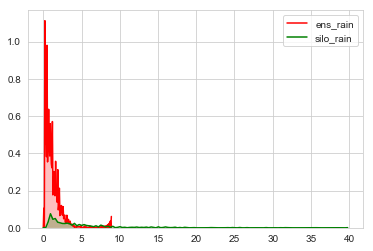

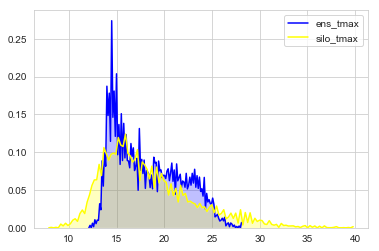

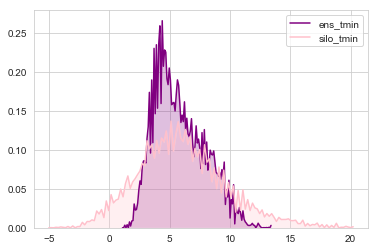

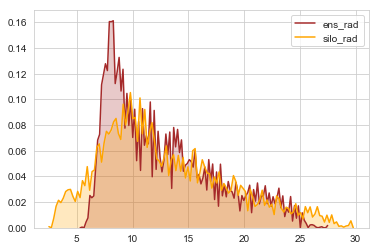

In [70]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sRain = fcast_vs_obs["silo_rain"]
eRain = fcast_vs_obs["ens_rain"]
sTMa = fcast_vs_obs["silo_tmax"]
eTMa = fcast_vs_obs["ens_tmax"]
sTMi = fcast_vs_obs["silo_tmin"]
eTMi = fcast_vs_obs["ens_tmin"]
sRad = fcast_vs_obs["silo_rad"]
eRad = fcast_vs_obs["ens_rad"]






sns.set_style('whitegrid')
ax1 = sns.kdeplot(eRain, bw=0, color = 'red', shade = 'true')
ax1 = sns.kdeplot(sRain, bw=0, color = 'green', shade = 'true')
plt.show()

sns.set_style('whitegrid')
ax2 = sns.kdeplot(eTMa, bw=0, color = 'blue', shade = 'true')
ax2 = sns.kdeplot(sTMa, bw=0, color = 'yellow', shade = 'true')
plt.show()

sns.set_style('whitegrid')
ax3 = sns.kdeplot(eTMi, bw=0, color = 'purple', shade = 'true')
ax3 = sns.kdeplot(sTMi, bw=0, color = 'pink', shade = 'true')
plt.show()

sns.set_style('whitegrid')
ax4 = sns.kdeplot(eRad, bw=0, color = 'brown', shade = 'true')
ax4 = sns.kdeplot(sRad, bw=0, color = 'orange', shade = 'true')
plt.show()

In [34]:
sns.FacetGrid

seaborn.axisgrid.FacetGrid